
# SLAP IT WITH THE SHAP

In [1]:
import os
import sys
sys.path.append(os.path.realpath(".."))
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="6"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, Conv2D, Flatten, Dropout
import ptetaphi_nn
import tools
with open("../filepath.txt", 'r') as f:
    filename = f.read().strip("\n")
    
s_table = tools.open_file(filename, sort_by="tag")

Using TensorFlow backend.
sorting data by tag


In [2]:
nt3 = s_table.nbtags==3  # 3 b tags
events = s_table[nt3]
#print(len(events))


cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

# then ensure require pt >= 40 and |eta| <= 2.5
#pt_filter = events.resolved_lv.pt < 40
#events.resolved_lv.pt[pt_filter] = 0
#events.resolved_lv.eta[pt_filter] = 0
#events.resolved_lv.phi[pt_filter] = 0

#eta_filter = (events.resolved_lv.eta >= -2.5) & (events.resolved_lv.eta >= 2.5)
#events.resolved_lv.pt[eta_filter] = 0
#events.resolved_lv.eta[eta_filter] = 0
#events.resolved_lv.phi[eta_filter] = 0
#print(events.resolved_lv.pt[0])
#print(events.tag[0])
print(len(events))

313660


In [3]:
import importlib
importlib.reload(ptetaphi_nn)
importlib.reload(tools)
#nn = ptetaphi_nn.PtEtaPhiNN(events, load=("models/architecture_same_filters.json", "models/weights_same_filters.h5"), njets=10)
nn = ptetaphi_nn.PtEtaPhiNN(events, load=("../models/architecture_06_07_2020.json", "../models/weights_06_07_2020.h5"), njets=10, chop=0)
nn.model.summary()

Loading model... 
Using architecture: ../models/architecture_06_07_2020.json 
and weights: ../models/weights_06_07_2020.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 700)               21700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               350500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               150300  

100%|██████████| 62732/62732 [00:00<00:00, 63688.73it/s]
overall accuracy: 86.08 percent
ignoring 2.69 percent (1686 events) of 62732 events


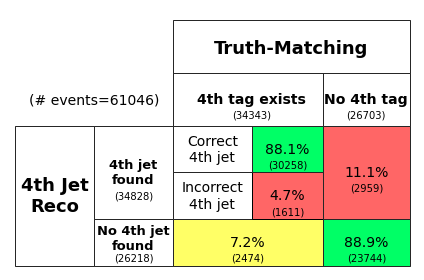

In [4]:
#import awkward
#import uproot_methods as urm
#import importlib
#importlib.reload(tools)

#one_event = awkward.Table()

#for index in range(12):
#    lv = urm.TLorentzVectorArray.from_ptetaphie(events.resolved_lv.pt[index].reshape(1, -1),
#                                                events.resolved_lv.eta[index].reshape(1, -1),
#                                                events.resolved_lv.phi[index].reshape(1, -1),
#                                                events.resolved_lv.E[index].reshape(1, -1))

#    one_event.resolved_lv = lv
#    one_event.truth = events.truth[index].reshape(1, -1)
#    one_event.tag = events.tag[index].reshape(1, -1)

#    selections = nn.evaluate(one_event, output=None)[0]
#    print(f"Event {index}")
#    print("|Tag|Truth|Sel|pt")
#    for i in range(events.njets[index]):
#        print(f"| {events.truth[index][i]} |  {events.tag[index][i]}  | {selections[i]} | {events.resolved_lv.pt[index][i]:.3f}")
#    print()
selections = nn.evaluate()

getting nn scores
working on jet 0


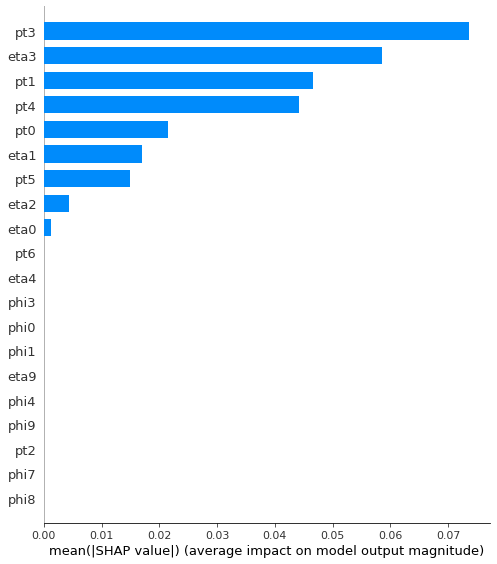

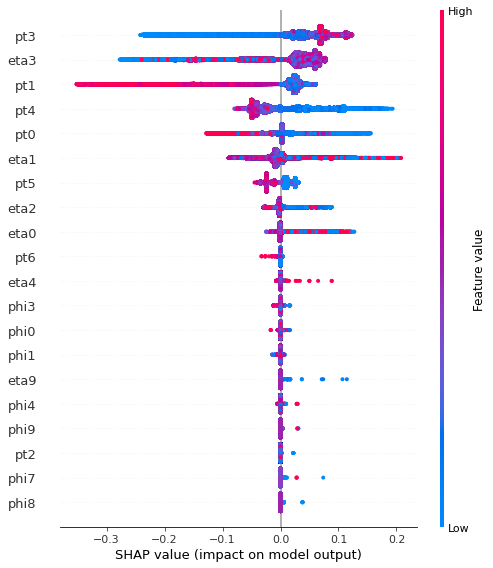

<Figure size 432x288 with 0 Axes>

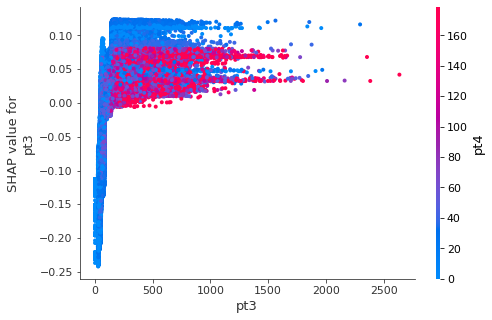

working on jet 1


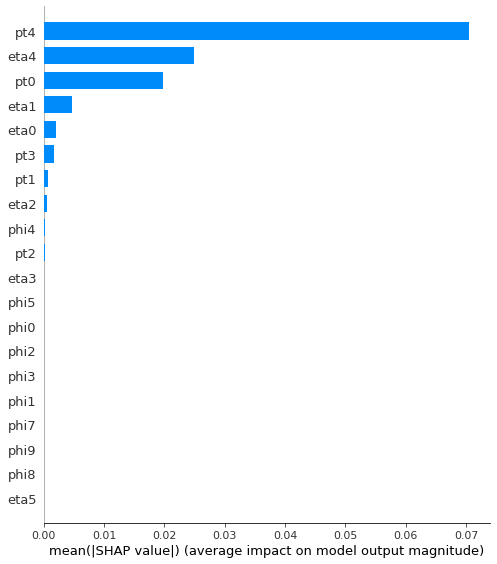

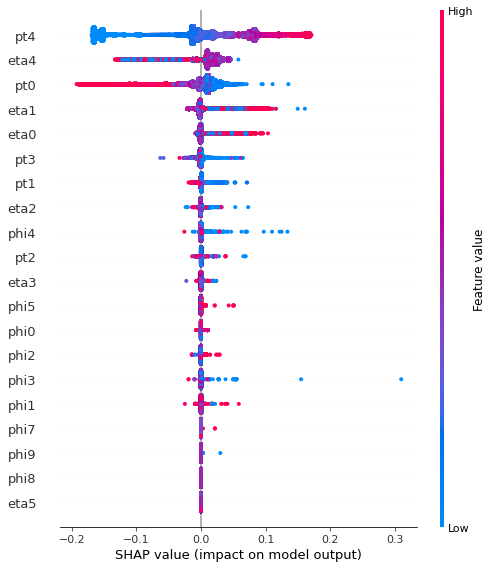

<Figure size 432x288 with 0 Axes>

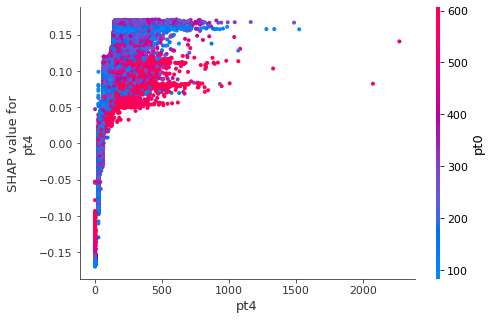

working on jet 2


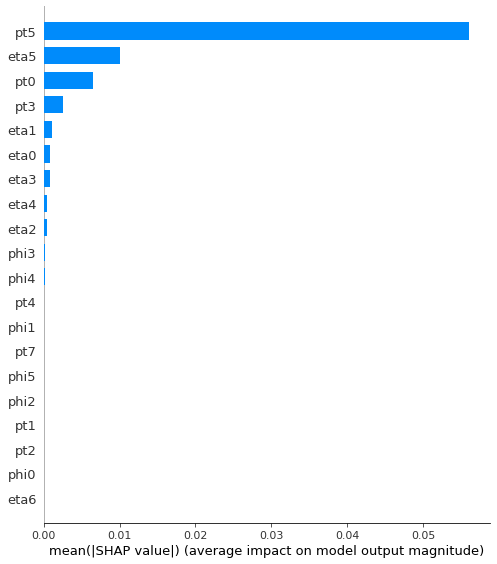

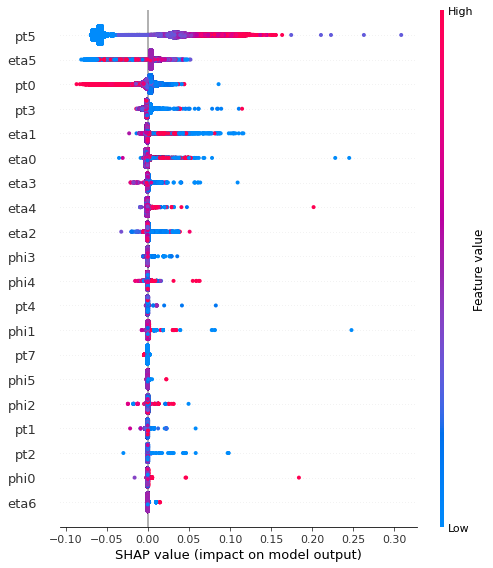

<Figure size 432x288 with 0 Axes>

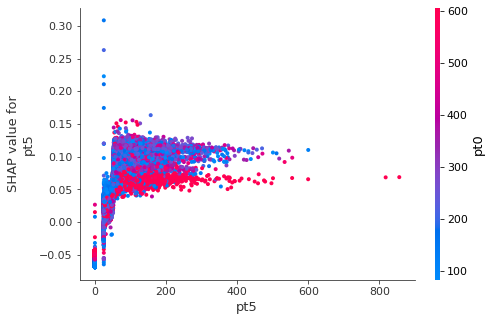

working on jet 3


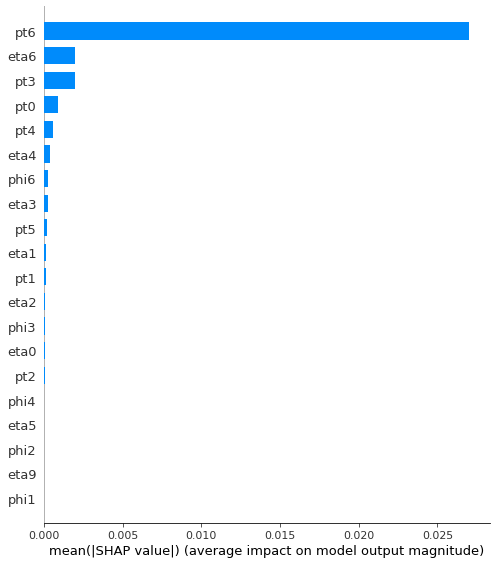

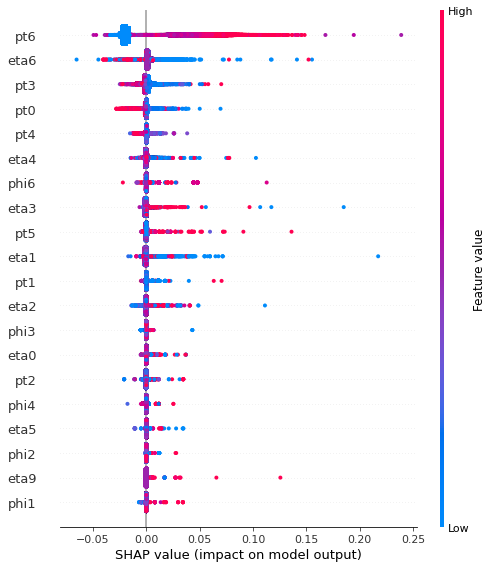

<Figure size 432x288 with 0 Axes>

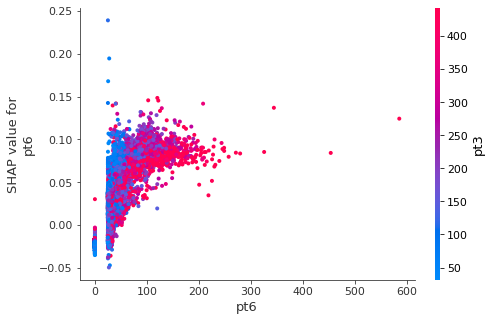

working on jet 4


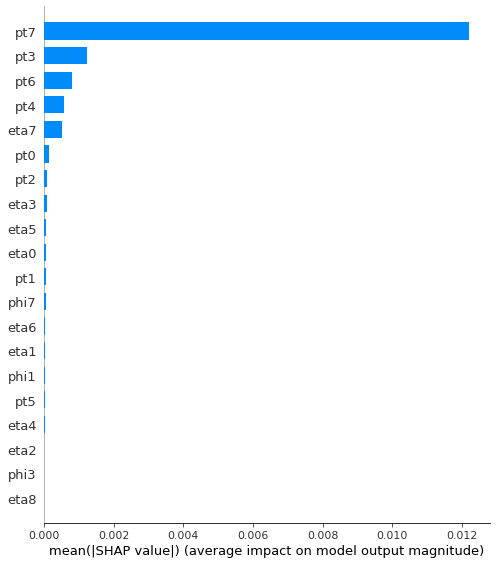

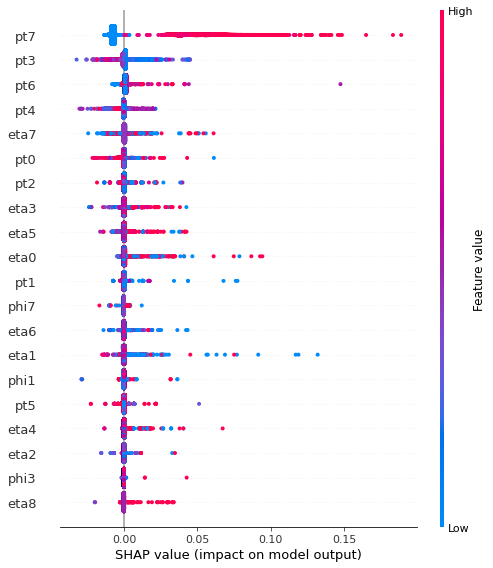

<Figure size 432x288 with 0 Axes>

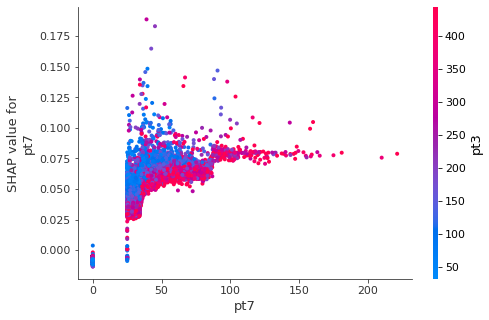

working on jet 5


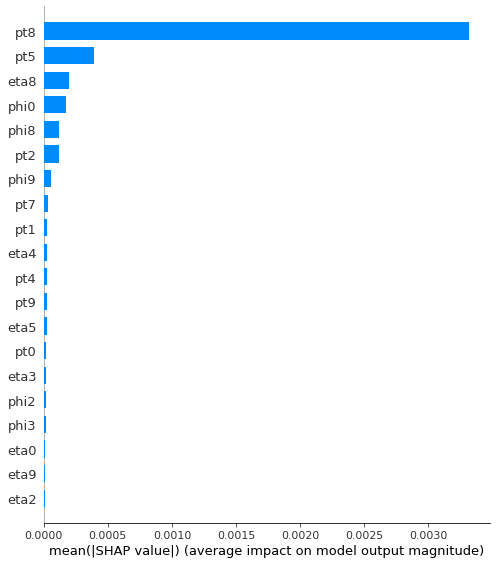

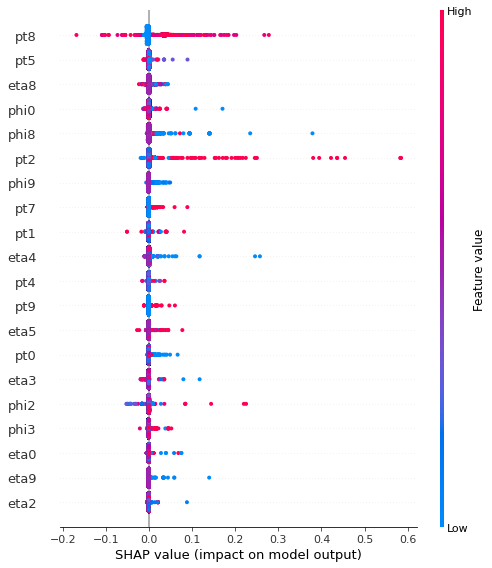

<Figure size 432x288 with 0 Axes>

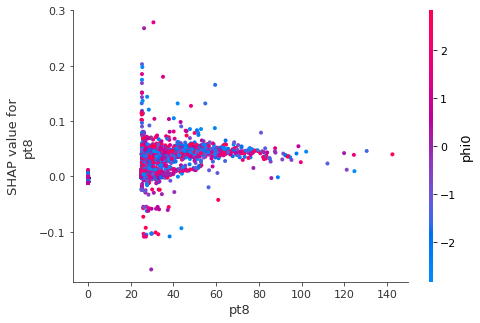

working on jet 6


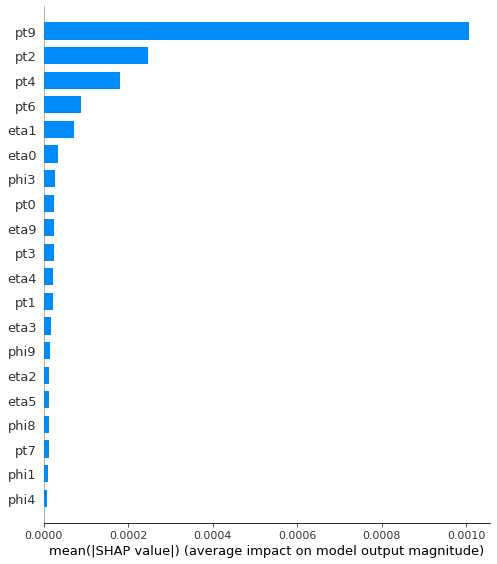

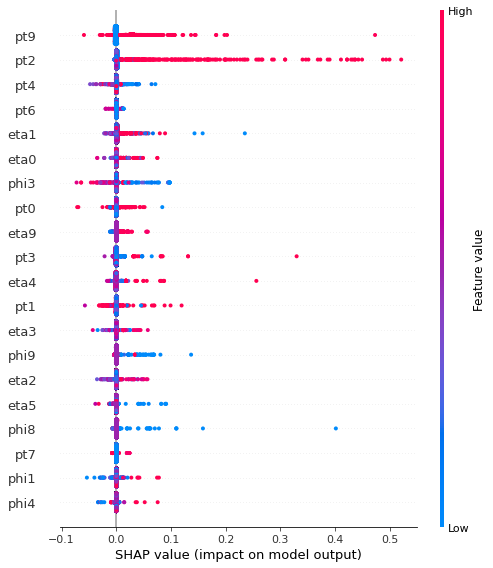

<Figure size 432x288 with 0 Axes>

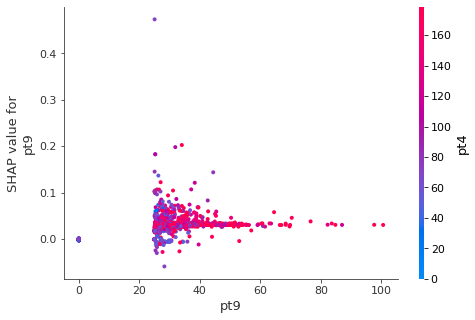

working on jet 7


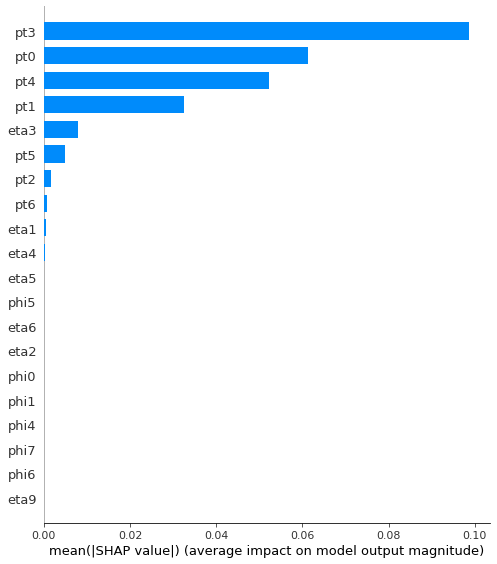

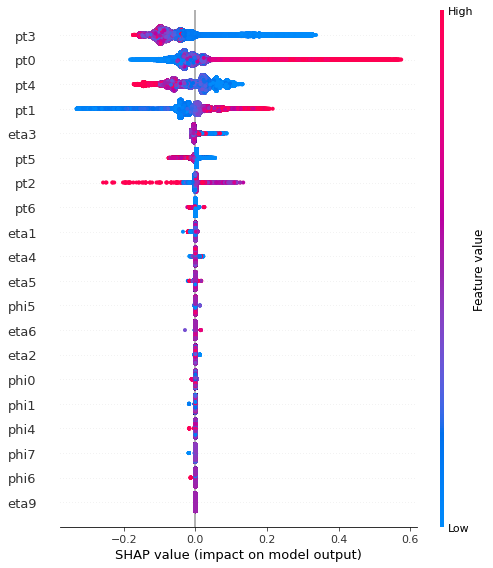

ValueError: Could not find feature named: pt10

In [5]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

##### THE REAL SHAP BEGINS HERE ######

# Creating pandas dataframe from numpy arrays
X = pd.DataFrame({
    'pt0': events.resolved_lv.pt[:,0],
    'pt1': events.resolved_lv.pt[:,1],
    'pt2': events.resolved_lv.pt[:,2],
    'pt3': events.resolved_lv.pt[:,3],
    'pt4': events.resolved_lv.pt[:,4],
    'pt5': events.resolved_lv.pt[:,5],
    'pt6': events.resolved_lv.pt[:,6],
    'pt7': events.resolved_lv.pt[:,7],
    'pt8': events.resolved_lv.pt[:,8],
    'pt9': events.resolved_lv.pt[:,9],
    'eta0': events.resolved_lv.eta[:,0],
    'eta1': events.resolved_lv.eta[:,1],
    'eta2': events.resolved_lv.eta[:,2],
    'eta3': events.resolved_lv.eta[:,3],
    'eta4': events.resolved_lv.eta[:,4],
    'eta5': events.resolved_lv.eta[:,5],
    'eta6': events.resolved_lv.eta[:,6],
    'eta7': events.resolved_lv.eta[:,7],
    'eta8': events.resolved_lv.eta[:,8],
    'eta9': events.resolved_lv.eta[:,9],
    'phi0': events.resolved_lv.phi[:,0],
    'phi1': events.resolved_lv.phi[:,1],
    'phi2': events.resolved_lv.phi[:,2],
    'phi3': events.resolved_lv.phi[:,3],
    'phi4': events.resolved_lv.phi[:,4],
    'phi5': events.resolved_lv.phi[:,5],
    'phi6': events.resolved_lv.phi[:,6],
    'phi7': events.resolved_lv.phi[:,7],
    'phi8': events.resolved_lv.phi[:,8],
    'phi9': events.resolved_lv.phi[:,9],
    })

print("getting nn scores")
nn_score = nn.evaluate(events, output="nn_score")

for n in range(8):
    print("working on jet", n)
    # n-th jet
    Y = pd.DataFrame({'output': nn_score[:,n]})

    # Split the data into train and test data:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    # Build the model with the random forest regression algorithm:
    model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
    model.fit(X_train, Y_train)

    f = plt.figure()
    shap_values = shap.TreeExplainer(model).shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    f.savefig(f"plot_bar_{n}.png", bbox_inches='tight')

    f = plt.figure()
    shap.summary_plot(shap_values, X_train)
    f.savefig(f"plot_violin_{n}.png", bbox_inches='tight')

    f = plt.figure()
    shap.dependence_plot(f"pt{n+3}", shap_values, X_train)
    f.savefig(f"plot_dependence_{n}.png", bbox_inches='tight')


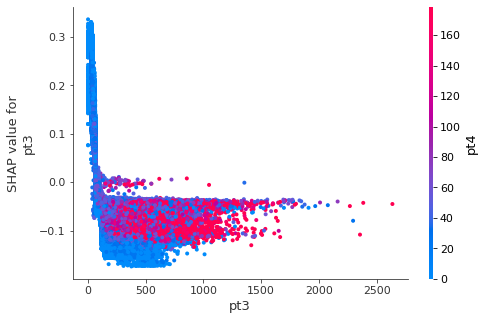

In [6]:
shap.dependence_plot("pt3", shap_values, X_train)
